In [1]:
import matplotlib.pyplot as plt
def get_academic_colors():
    """返回您指定的学术风格色板"""
    return {
        'primary': '#333333',
        'secondary': '#000000',
        'background': '#F0F0F0',
        'gridline': '#D9D9D9',
        'categorical': [
            '#FF8C00',  # 明亮橙色
            '#6A7FDB',  # 明亮靛蓝
            '#52BCA3',  # 浅青绿
            '#A0522D',  # 深红棕色
            '#DA70D6',  # 明亮兰花紫
            '#87CEEB',  # 天蓝色
        ]
    }

def set_academic_style():
    """设置图表的全局学术风格"""
    colors = get_academic_colors()
    plt.style.use('seaborn-v0_8-paper')
    # --- 核心修正：提供一个备选字体列表，以增强兼容性 ---
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'Microsoft JhengHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['figure.facecolor'] = colors['background']
    plt.rcParams['axes.facecolor'] = colors['background']
    plt.rcParams['text.color'] = colors['primary']
    plt.rcParams['axes.labelcolor'] = colors['primary']
    plt.rcParams['xtick.color'] = colors['secondary']
    plt.rcParams['ytick.color'] = colors['secondary']
    plt.rcParams['grid.color'] = colors['gridline']
    # --- 核心修改：再次增大全局基础字号 ---
    plt.rcParams['font.size'] = 22

In [3]:
# 残差分位数加速计算
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import Parallel, delayed # 导入用于并行计算的库
import os # 导入os库以获取CPU核心数量

# =================================================================== #
#                       【1. 文件路径配置与模拟数据生成】             #
# =================================================================== #

# 请根据您的实际文件路径修改以下变量。
# 如果文件不存在，代码将自动创建模拟数据以确保可运行性。
RESIDUALS_FILE_3_1 = Path('E:/PBROE/ch3/pbroe3.1Residuals.csv')
RESIDUALS_FILE_4_1 = Path('E:/PBROE/ch4/pbroe4.1Residuals.csv')

# 输出目录设置为当前目录，如您所要求
OUTPUT_DIR = Path('.')
OUTPUT_DIR.mkdir(exist_ok=True) # 确保输出目录存在
#
# # --- 为演示目的创建模拟残差数据文件 ---
# # 在实际应用中，您将使用真实数据。如果您的真实文件已存在，此函数将不会执行创建操作。
# def create_dummy_residuals_file(file_path, residual_col_name, num_stocks=200, num_months=120):
#     """
#     创建模拟残差数据文件。
#     参数:
#         file_path (Path): 要创建的模拟文件的路径。
#         residual_col_name (str): 残差列的名称 ('residual_zscore' 或 'residual_zscore_adj')。
#         num_stocks (int): 模拟的股票数量。
#         num_months (int): 模拟的月份数量。
#     """
#     if not file_path.exists():
#         print(f"检测到文件 '{file_path}' 不存在，正在创建模拟数据...")
#         all_data = []
#         start_date = pd.to_datetime('2010-01-31')
#         for i in range(num_stocks):
#             stkcd = str(600000 + i).zfill(6) # 模拟A股代码格式
#             dates = pd.date_range(start=start_date, periods=num_months, freq='M')
#             # 模拟残差值，使其具有一定的序列相关性，更接近真实数据分布
#             residuals = np.random.randn(num_months).cumsum() / 5 + np.random.randn(num_months) * 0.2
#             df_stock = pd.DataFrame({
#                 '调入日期': dates,
#                 'stkcd': stkcd,
#                 residual_col_name: residuals,
#                 'shortname': f'模拟公司{stkcd}',
#                 'indnme1': '模拟行业'
#             })
#             all_data.append(df_stock)
#         pd.concat(all_data).to_csv(file_path, index=False)
#         print(f"模拟文件 '{file_path}' 创建成功。")
#
# # 调用函数创建模拟文件（如果不存在）
# create_dummy_residuals_file(RESIDUALS_FILE_3_1, 'residual_zscore')
# create_dummy_residuals_file(RESIDUALS_FILE_4_1, 'residual_zscore_adj')

# =================================================================== #
#                           【2. 数据加载与预处理】                   #
# =================================================================== #

def load_and_preprocess_residuals(file_path):
    """
    加载残差数据并进行预处理。
    参数:
        file_path (Path): 残差数据文件的路径。
    返回:
        pd.DataFrame: 加载并预处理后的DataFrame。
    """
    try:
        df = pd.read_csv(file_path)
        df['stkcd'] = df['stkcd'].astype(str).str.zfill(6)
        df['调入日期'] = pd.to_datetime(df['调入日期'])
        # 确保数据按股票代码和日期排序，这对于时序计算至关重要
        df = df.sort_values(by=['stkcd', '调入日期']).reset_index(drop=True)
        print(f"文件 '{file_path}' 加载成功，共 {len(df)} 条记录。")
        return df
    except FileNotFoundError:
        print(f"错误：未找到文件 '{file_path}'。请确保文件路径正确。")
        return pd.DataFrame()

df_residuals_3_1 = load_and_preprocess_residuals(RESIDUALS_FILE_3_1)
df_residuals_4_1 = load_and_preprocess_residuals(RESIDUALS_FILE_4_1)

# =================================================================== #
#                       【3. 时序残差分位数计算（并行版本）】         #
# =================================================================== #

def calculate_quantiles_for_single_stock(stock_df, residual_col, periods):
    """
    辅助函数：计算单个股票数据的时序残差分位数。
    此函数将在并行处理中被调用。
    参数:
        stock_df (pd.DataFrame): 单个股票的残差数据。
        residual_col (str): 残差列的名称。
        periods (list): 需要计算分位数的历史周期列表。
    返回:
        pd.DataFrame: 包含新增时序分位数列的单个股票DataFrame。
    """
    # 确保股票数据按日期排序，这对于滚动窗口计算至关重要
    stock_df = stock_df.sort_values(by='调入日期').copy() # 使用 .copy() 避免 SettingWithCopyWarning

    for period in periods:
        quantile_col_name = f'residual_quantile_{period}m'
        # 对残差列应用滚动计算
        # rank(pct=True) 计算百分位排名 (0-1之间)
        # iloc[-1] 获取当前（窗口中最后一个）元素的排名
        stock_df[quantile_col_name] = stock_df[residual_col].rolling(
            window=period, min_periods=1
        ).apply(lambda y: y.rank(pct=True).iloc[-1], raw=False)
    return stock_df

def calculate_time_series_quantiles(df, residual_col, periods=[10, 20, 50]):
    """
    计算个股时序残差分位数的主函数（并行版本）。
    将DataFrame按股票代码分组，并使用多核并行处理每个股票组。
    参数:
        df (pd.DataFrame): 包含残差数据（'stkcd', '调入日期', residual_col）的DataFrame。
        residual_col (str): 残差列的名称，例如 'residual_zscore' 或 'residual_zscore_adj'。
        periods (list): 需要计算分位数的历史周期列表（以月为单位）。
    返回:
        pd.DataFrame: 包含新增时序分位数列的完整DataFrame。
    """
    if df.empty:
        print("输入DataFrame为空，无法计算时序残差分位数。")
        return df

    # 检查指定的残差列是否存在于DataFrame中
    if residual_col not in df.columns:
        print(f"错误：DataFrame中未找到残差列 '{residual_col}'。请检查列名是否正确。")
        return df

    print(f"\n开始计算时序残差分位数（并行），针对列: '{residual_col}'...")

    # 获取CPU核心数量，用于并行计算
    num_cores = os.cpu_count()
    if num_cores is None:
        num_cores = 1 # 如果无法检测到核心数，则默认为单核
    print(f"检测到 {num_cores} 个CPU核心，将使用所有核心进行并行计算。")

    # 将DataFrame按股票代码分组，并转换为列表，以便 joblib 进行并行处理
    grouped_dfs = [group for _, group in df.groupby('stkcd')]

    # 使用 joblib.Parallel 进行并行计算
    # n_jobs=-1 表示使用所有可用的CPU核心
    results = Parallel(n_jobs=-1)(
        delayed(calculate_quantiles_for_single_stock)(stock_df, residual_col, periods)
        for stock_df in grouped_dfs
    )

    # 将所有并行计算的结果合并回一个DataFrame
    # 重新排序以保持原始顺序，并重置索引，确保最终DataFrame的结构一致性
    df_quantiles_parallel = pd.concat(results).sort_values(by=['stkcd', '调入日期']).reset_index(drop=True)

    print("时序残差分位数并行计算完成。")
    return df_quantiles_parallel

# =================================================================== #
#                       【4. 执行计算与保存结果】                     #
# =================================================================== #

# 对 pbroe3.1 残差数据计算时序分位数
# 注意：这里将 residual_col 设置为 'residual_zscore'，以匹配文件中的列名
if not df_residuals_3_1.empty:
    df_residuals_3_1_with_quantiles = calculate_time_series_quantiles(
        df_residuals_3_1.copy(), residual_col='residual_zscore'
    )
    output_path_3_1 = OUTPUT_DIR / 'pbroe3.1Residuals_with_quantiles.csv'
    df_residuals_3_1_with_quantiles.to_csv(output_path_3_1, index=False)
    print(f"\npbroe3.1 残差分位数数据已保存至: {output_path_3_1}")
else:
    print("pbroe3.1 残差数据加载失败，跳过时序分位数计算。")

print("\n" + "="*80 + "\n")

# 对 pbroe4.1 残差数据计算时序分位数
# 注意：这里将 residual_col 设置为 'residual_zscore_adj'，以匹配文件中的列名
if not df_residuals_4_1.empty:
    df_residuals_4_1_with_quantiles = calculate_time_series_quantiles(
        df_residuals_4_1.copy(), residual_col='residual_zscore_adj'
    )
    output_path_4_1 = OUTPUT_DIR / 'pbroe4.1Residuals_with_quantiles.csv'
    df_residuals_4_1_with_quantiles.to_csv(output_path_4_1, index=False)
    print(f"\npbroe4.1 残差分位数数据已保存至: {output_path_4_1}")
else:
    print("pbroe4.1 残差数据加载失败，跳过时序分位数计算。")


文件 'E:\PBROE\ch3\pbroe3.1Residuals.csv' 加载成功，共 551604 条记录。
文件 'E:\PBROE\ch4\pbroe4.1Residuals.csv' 加载成功，共 499191 条记录。

开始计算时序残差分位数（并行），针对列: 'residual_zscore'...
检测到 192 个CPU核心，将使用所有核心进行并行计算。
时序残差分位数并行计算完成。

pbroe3.1 残差分位数数据已保存至: pbroe3.1Residuals_with_quantiles.csv



开始计算时序残差分位数（并行），针对列: 'residual_zscore_adj'...
检测到 192 个CPU核心，将使用所有核心进行并行计算。
时序残差分位数并行计算完成。

pbroe4.1 残差分位数数据已保存至: pbroe4.1Residuals_with_quantiles.csv


In [1]:
# 交集策略

import sys
from pathlib import Path
import pandas as pd

# 将当前目录添加到 Python 路径，以便导入 backtestch5.py
# 如果 backtestch5.py 在其他位置，请修改此行
sys.path.append(str(Path('.').resolve()))

import backtestch5 as bt # 导入回测引擎

# =================================================================== #
#                       【1. 配置回测参数】                           #
# =================================================================== #

# 定义基础回测配置字典
base_config = {
    'STRATEGY_TYPE': 'pbroe5_0_fusion', # PBROE 5.0 融合策略类型

    # pbroe3.1 和 pbroe4.1 的原始残差文件路径
    'RESIDUAL_FILE_P3': Path('E:/PBROE/ch3/pbroe3.1Residuals.csv'),
    'RESIDUAL_FILE_P4': Path('E:/PBROE/ch4/pbroe4.1Residuals.csv'),

    # 横截面残差（pbroe3.1和pbroe4.1）的筛选百分位数阈值
    'CROSS_SECTIONAL_QUANTILE': 0.2,

    # 时序残差分位数的筛选阈值
    'TIME_SERIES_QUANTILE_THRESHOLD': 0.2,

    # 股票收益率数据文件路径
    'RETURNS_FILE': Path('E:/PBROE/data/TRDNEW_Mnth.csv'),
    # 基准指数数据文件路径
    'BENCHMARK_FILE': Path(r'E:\PBROE\data\benchmark_indices.csv'), # 确保路径和文件名正确
    'BENCHMARK_CODE': '000300', # 沪深300指数代码
    'RISK_FREE_RATE': 0.03, # 无风险利率，年化

    'BACKTEST_START_DATE': '2010-05-01', # 回测开始日期
    'BACKTEST_END_DATE': '2025-04-30', # 回测结束日期

    'OUTPUT_DIR': Path('.') # 输出文件保存到当前目录
}

# 确保输出目录存在
base_config['OUTPUT_DIR'].mkdir(exist_ok=True)

# 定义要回测的时序残差分位数配置
# 每个字典代表一个时序残差分位数文件及其对应的原始残差列名（用于命名策略）
ts_quantile_configs = [
    {'file': Path('E:/PBROE/ch5/pbroe3.1Residuals_with_quantiles.csv'), 'base_name_prefix': 'PBROE_5.0_from_3.1_TS'},
    {'file': Path('E:/PBROE/ch5/pbroe4.1Residuals_with_quantiles.csv'), 'base_name_prefix': 'PBROE_5.0_from_4.1_TS'}
]
ts_quantile_periods = [10, 20, 50] # 要回测的周期（月）

# 用于收集所有策略的绩效指标和累计收益
all_performance_metrics = []
all_cumulative_returns_df = pd.DataFrame()

# =================================================================== #
#                       【2. 批量执行回测】                           #
# =================================================================== #

print("开始批量执行 PBROE 5.0 策略回测...")

# 预加载基准数据，避免在循环中重复加载
# 注意：这里调用的是 bt.load_and_preprocess_data，它会返回 (returns_df, benchmark_df)
# 我们只需要 benchmark_df，所以取 [1]。同时传递日期参数。
_, benchmark_df_for_plot = bt.load_and_preprocess_data(
    base_config['RETURNS_FILE'],
    base_config['BENCHMARK_FILE'],
    base_config['BENCHMARK_CODE'],
    pd.to_datetime(base_config['BACKTEST_START_DATE']), # 传递日期参数
    pd.to_datetime(base_config['BACKTEST_END_DATE'])     # 传递日期参数
)

if benchmark_df_for_plot is not None:
    benchmark_df_for_plot.set_index('date', inplace=True)
    # 计算基准累计收益并归一化到1
    benchmark_cumulative_return = (1 + benchmark_df_for_plot['benchmark_return']).cumprod()
    if not benchmark_cumulative_return.empty:
        benchmark_cumulative_return = benchmark_cumulative_return / benchmark_cumulative_return.iloc[0]
    all_cumulative_returns_df[f"基准 ({base_config['BENCHMARK_CODE']})"] = benchmark_cumulative_return
else:
    print("警告: 无法加载基准数据，累计收益数据中将不包含基准。")


for ts_config in ts_quantile_configs:
    current_ts_quantile_file = ts_config['file']
    base_name_prefix = ts_config['base_name_prefix']

    for period in ts_quantile_periods:
        current_ts_quantile_col = f'residual_quantile_{period}m'

        # 构建当前策略的完整配置
        current_strategy_config = base_config.copy()
        current_strategy_config['STRATEGY_NAME'] = f"{base_name_prefix}_{period}M"
        current_strategy_config['RESIDUAL_FILE_TS_QUANTILE'] = current_ts_quantile_file
        current_strategy_config['TS_QUANTILE_COL'] = current_ts_quantile_col

        print(f"\n--- 正在回测策略: {current_strategy_config['STRATEGY_NAME']} ---")

        # 执行回测，并检查返回值是否为 None
        # 关键修正：先将bt.main的返回值赋给一个变量，再进行检查和解包
        main_result = bt.main(current_strategy_config)

        if main_result is not None: # 只有当 main_result 不为 None 时才尝试解包
            merged_returns_df, metrics = main_result
            if metrics: # 只有当 metrics 不为 None 时才添加到列表中
                metrics['Strategy'] = current_strategy_config['STRATEGY_NAME']
                all_performance_metrics.append(metrics)
            else:
                print(f"警告: 策略 {current_strategy_config['STRATEGY_NAME']} 未能生成有效的绩效指标，可能回测失败或数据不足。")

            if merged_returns_df is not None and not merged_returns_df.empty:
                # 确保 'date' 列是索引，用于合并累计收益
                temp_cum_returns = merged_returns_df.set_index('date')['cumulative_return'].rename(current_strategy_config['STRATEGY_NAME'])

                # 合并到总的累计收益DataFrame中
                # 使用 outer join 确保所有日期都包含，并用 ffill 填充缺失值
                all_cumulative_returns_df = pd.merge(all_cumulative_returns_df, temp_cum_returns.to_frame(),
                                                    left_index=True, right_index=True, how='outer')
                # 确保新加入的策略累计收益也从1开始
                if not all_cumulative_returns_df[current_strategy_config['STRATEGY_NAME']].empty:
                    all_cumulative_returns_df[current_strategy_config['STRATEGY_NAME']] = \
                        all_cumulative_returns_df[current_strategy_config['STRATEGY_NAME']] / \
                        all_cumulative_returns_df[current_strategy_config['STRATEGY_NAME']].iloc[0]
            else:
                print(f"警告: 策略 {current_strategy_config['STRATEGY_NAME']} 未能生成有效的累计收益数据。")
        else:
            print(f"警告: 策略 {current_strategy_config['STRATEGY_NAME']} 的回测主函数返回 None，表示回测失败或中止。跳过此策略的结果处理。")


# 填充合并后可能出现的NaN值（例如，不同策略起始日期不同）
all_cumulative_returns_df.ffill(inplace=True)
all_cumulative_returns_df.bfill(inplace=True) # 也向后填充，以防开头有NaN

print("\n所有策略回测完成。")

# =================================================================== #
#                       【3. 汇总结果与保存】                         #
# =================================================================== #

# 汇总绩效指标并保存
if all_performance_metrics:
    final_performance_df = pd.DataFrame(all_performance_metrics).set_index('Strategy')
    print("\n--- 所有策略绩效汇总 ---")
    # 格式化输出，只对 float 类型且包含 '率' 或 '回撤' 的列显示百分比
    formatted_performance_df = final_performance_df.copy()
    for col in formatted_performance_df.columns:
        if formatted_performance_df[col].dtype == 'float64' and ('率' in col or '回撤' in col):
            formatted_performance_df[col] = formatted_performance_df[col].apply(lambda x: f"{x:.2%}")
        else:
            formatted_performance_df[col] = formatted_performance_df[col].apply(lambda x: f"{x:.4f}")

    print(formatted_performance_df.to_string()) # 使用 to_string 确保完整显示

    summary_metrics_path = base_config['OUTPUT_DIR'] / 'pbroe5.2all_strategies_performance.csv'
    final_performance_df.to_csv(summary_metrics_path, encoding='utf-8-sig', float_format='%.6f')
    print(f"\n所有策略绩效汇总已保存至: {summary_metrics_path}")
else:
    print("\n没有生成任何策略绩效数据。")

# 保存所有策略的累计收益数据
if not all_cumulative_returns_df.empty:
    all_cum_returns_path = base_config['OUTPUT_DIR'] / 'pbroe5.2all_cumulative_returns.csv'
    all_cumulative_returns_df.to_csv(all_cum_returns_path, encoding='utf-8-sig', float_format='%.6f')
    print(f"所有策略累计收益数据已保存至: {all_cum_returns_path}")
else:
    print("\n没有生成任何累计收益数据。")


开始批量执行 PBROE 5.0 策略回测...
--- 步骤 2: 加载并预处理收益与基准数据 ---
股票收益率文件 'TRDNEW_Mnth.csv' 加载成功。
基准指数文件 'benchmark_indices.csv' 加载成功。
股票收益率数据已过滤至回测区间，共 649885 条。
基准收益率数据已过滤至回测区间，共 180 条。
数据预处理完成。


--- 正在回测策略: PBROE_5.0_from_3.1_TS_10M ---
--- 步骤 1: 构建 PBROE 5.0 融合投资组合 ---
所有残差和时序分位数文件加载并过滤成功 (p3:499809, p4:458508, ts:499809条)。
找到 180 个共同的调仓日期进行比较。
已成功构建 PBROE 5.0 融合投资组合，共包含 20671 条持仓记录。

--- 步骤 2: 加载并预处理收益与基准数据 ---
股票收益率文件 'TRDNEW_Mnth.csv' 加载成功。
基准指数文件 'benchmark_indices.csv' 加载成功。
股票收益率数据已过滤至回测区间，共 649885 条。
基准收益率数据已过滤至回测区间，共 180 条。
数据预处理完成。

--- 步骤 3: 执行回测 (向量化加速版) ---
回测完成，已生成 180 条月度收益记录。

--- 步骤 4: 计算年化换手率 (向量化加速版) ---
计算完成。预估年化换手率: 555.31%

--- 步骤 5: 计算绩效并保存结果 ---

--- PBROE_5.0_from_3.1_TS_10M 绩效简报 ---
年化收益率:       20.42%
年化波动率:       27.73%
夏普比率:        62.81%
最大回撤:        -35.02%
年化换手率:       555.31%
年化超额收益率:     19.03%
信息比率:        105.26%
跟踪误差:        0.1808
基准年化收益率:     1.39%
累计收益率:       1522.63%

月度收益率详情已保存至: PBROE_5.0_from_3.1_TS_10M_returns.csv
绩效指标已保存至: PBROE_5.0_from_3.1_TS_10M

In [2]:
# 单独分位数

import sys
from pathlib import Path
import pandas as pd

# 将当前目录添加到 Python 路径，以便导入 backtestch5.py
# 如果 backtestch5.py 在其他位置，请修改此行
sys.path.append(str(Path('.').resolve()))

import backtestch5 as bt # 导入回测引擎

# =================================================================== #
#                       【1. 配置回测参数】                           #
# =================================================================== #

# 定义基础回测配置字典
base_config = {
    'STRATEGY_TYPE': 'single_ts_quantile', # 策略类型：单一时序残差分位数策略

    # 股票收益率数据文件路径
    'RETURNS_FILE': Path('E:/PBROE/data/TRDNEW_Mnth.csv'),
    # 基准指数数据文件路径
    'BENCHMARK_FILE': Path(r'E:\PBROE\data\benchmark_indices.csv'), # 确保路径和文件名正确
    'BENCHMARK_CODE': '000300', # 沪深300指数代码
    'RISK_FREE_RATE': 0.03, # 无风险利率，年化

    'BACKTEST_START_DATE': '2010-05-01', # 回测开始日期
    'BACKTEST_END_DATE': '2025-04-30', # 回测结束日期

    'OUTPUT_DIR': Path('.') # 输出文件保存到当前目录
}

# 确保输出目录存在
base_config['OUTPUT_DIR'].mkdir(exist_ok=True)

# 定义要回测的时序残差分位数配置
# 每个字典代表一个时序残差分位数文件及其对应的原始残差列名（用于命名策略）
ts_quantile_configs = [
    {'file': Path('E:/PBROE/ch5/pbroe3.1Residuals_with_quantiles.csv'), 'base_name_prefix': 'Single_TS_from_3.1'},
    {'file': Path('E:/PBROE/ch5/pbroe4.1Residuals_with_quantiles.csv'), 'base_name_prefix': 'Single_TS_from_4.1'}
]
ts_quantile_periods = [10, 20, 50] # 要回测的周期（月）

# 时序残差分位数的筛选阈值（例如 0.2 代表低于 20%）
# 这个参数现在直接在 base_config 中定义，并传递给新的构建函数
TIME_SERIES_QUANTILE_THRESHOLD = 0.1

# 用于收集所有策略的绩效指标和累计收益
all_performance_metrics = []
all_cumulative_returns_df = pd.DataFrame()

# =================================================================== #
#                       【2. 批量执行回测】                           #
# =================================================================== #

print("开始批量执行单一时序残差分位数策略回测...")

# 预加载基准数据，避免在循环中重复加载
_, benchmark_df_for_plot = bt.load_and_preprocess_data(
    base_config['RETURNS_FILE'],
    base_config['BENCHMARK_FILE'],
    base_config['BENCHMARK_CODE'],
    pd.to_datetime(base_config['BACKTEST_START_DATE']), # 传递日期参数
    pd.to_datetime(base_config['BACKTEST_END_DATE'])     # 传递日期参数
)

if benchmark_df_for_plot is not None:
    benchmark_df_for_plot.set_index('date', inplace=True)
    # 计算基准累计收益并归一化到1
    benchmark_cumulative_return = (1 + benchmark_df_for_plot['benchmark_return']).cumprod()
    if not benchmark_cumulative_return.empty:
        benchmark_cumulative_return = benchmark_cumulative_return / benchmark_cumulative_return.iloc[0]
    all_cumulative_returns_df[f"基准 ({base_config['BENCHMARK_CODE']})"] = benchmark_cumulative_return
else:
    print("警告: 无法加载基准数据，累计收益数据中将不包含基准。")


for ts_config in ts_quantile_configs:
    current_ts_quantile_file = ts_config['file']
    base_name_prefix = ts_config['base_name_prefix']

    for period in ts_quantile_periods:
        current_ts_quantile_col = f'residual_quantile_{period}m'

        # 构建当前策略的完整配置
        current_strategy_config = base_config.copy()
        current_strategy_config['STRATEGY_NAME'] = f"{base_name_prefix}_{period}M"
        current_strategy_config['RESIDUAL_FILE_TS_QUANTILE'] = current_ts_quantile_file
        current_strategy_config['TS_QUANTILE_COL'] = current_ts_quantile_col
        current_strategy_config['TIME_SERIES_QUANTILE_THRESHOLD'] = TIME_SERIES_QUANTILE_THRESHOLD # 从外部变量获取阈值

        print(f"\n--- 正在回测策略: {current_strategy_config['STRATEGY_NAME']} ---")

        # 执行回测，并检查返回值是否为 None
        main_result = bt.main(current_strategy_config)

        if main_result is not None: # 只有当 main_result 不为 None 时才尝试解包
            merged_returns_df, metrics = main_result
            if metrics: # 只有当 metrics 不为 None 时才添加到列表中
                metrics['Strategy'] = current_strategy_config['STRATEGY_NAME']
                all_performance_metrics.append(metrics)
            else:
                print(f"警告: 策略 {current_strategy_config['STRATEGY_NAME']} 未能生成有效的绩效指标，可能回测失败或数据不足。")

            if merged_returns_df is not None and not merged_returns_df.empty:
                # 确保 'date' 列是索引，用于合并累计收益
                temp_cum_returns = merged_returns_df.set_index('date')['cumulative_return'].rename(current_strategy_config['STRATEGY_NAME'])

                # 合并到总的累计收益DataFrame中
                # 使用 outer join 确保所有日期都包含，并用 ffill 填充缺失值
                all_cumulative_returns_df = pd.merge(all_cumulative_returns_df, temp_cum_returns.to_frame(),
                                                    left_index=True, right_index=True, how='outer')
                # 确保新加入的策略累计收益也从1开始
                if not all_cumulative_returns_df[current_strategy_config['STRATEGY_NAME']].empty:
                    all_cumulative_returns_df[current_strategy_config['STRATEGY_NAME']] = \
                        all_cumulative_returns_df[current_strategy_config['STRATEGY_NAME']] / \
                        all_cumulative_returns_df[current_strategy_config['STRATEGY_NAME']].iloc[0]
            else:
                print(f"警告: 策略 {current_strategy_config['STRATEGY_NAME']} 未能生成有效的累计收益数据。")
        else:
            print(f"警告: 策略 {current_strategy_config['STRATEGY_NAME']} 的回测主函数返回 None，表示回测失败或中止。跳过此策略的结果处理。")


# 填充合并后可能出现的NaN值（例如，不同策略起始日期不同）
all_cumulative_returns_df.ffill(inplace=True)
all_cumulative_returns_df.bfill(inplace=True) # 也向后填充，以防开头有NaN

print("\n所有策略回测完成。")

# =================================================================== #
#                       【3. 汇总结果与保存】                         #
# =================================================================== #

# 汇总绩效指标并保存
if all_performance_metrics:
    final_performance_df = pd.DataFrame(all_performance_metrics).set_index('Strategy')
    print("\n--- 所有策略绩效汇总 ---")
    # 格式化输出，只对 float 类型且包含 '率' 或 '回撤' 的列显示百分比
    formatted_performance_df = final_performance_df.copy()
    for col in formatted_performance_df.columns:
        if formatted_performance_df[col].dtype == 'float64' and ('率' in col or '回撤' in col):
            formatted_performance_df[col] = formatted_performance_df[col].apply(lambda x: f"{x:.2%}")
        else:
            formatted_performance_df[col] = formatted_performance_df[col].apply(lambda x: f"{x:.4f}")

    print(formatted_performance_df.to_string()) # 使用 to_string 确保完整显示

    summary_metrics_path = base_config['OUTPUT_DIR'] / 'pbroe5.1all_performance_summary.csv'
    final_performance_df.to_csv(summary_metrics_path, encoding='utf-8-sig', float_format='%.6f')
    print(f"\n所有策略绩效汇总已保存至: {summary_metrics_path}")
else:
    print("\n没有生成任何策略绩效数据。")

# 保存所有策略的累计收益数据
if not all_cumulative_returns_df.empty:
    all_cum_returns_path = base_config['OUTPUT_DIR'] / 'pbroe5.1all_cumulative_returns.csv'
    all_cumulative_returns_df.to_csv(all_cum_returns_path, encoding='utf-8-sig', float_format='%.6f')
    print(f"所有策略累计收益数据已保存至: {all_cum_returns_path}")
else:
    print("\n没有生成任何累计收益数据。")


开始批量执行单一时序残差分位数策略回测...
--- 步骤 2: 加载并预处理收益与基准数据 ---
股票收益率文件 'TRDNEW_Mnth.csv' 加载成功。
基准指数文件 'benchmark_indices.csv' 加载成功。
股票收益率数据已过滤至回测区间，共 649885 条。
基准收益率数据已过滤至回测区间，共 180 条。
数据预处理完成。


--- 正在回测策略: Single_TS_from_3.1_10M ---
--- 步骤 1: 构建单一时序残差分位数投资组合 (来自: pbroe3.1Residuals_with_quantiles.csv) ---
时序分位数文件加载并过滤成功 (499809条)。
已成功构建单一时序残差分位数投资组合，共包含 84758 条持仓记录。

--- 步骤 2: 加载并预处理收益与基准数据 ---
股票收益率文件 'TRDNEW_Mnth.csv' 加载成功。
基准指数文件 'benchmark_indices.csv' 加载成功。
股票收益率数据已过滤至回测区间，共 649885 条。
基准收益率数据已过滤至回测区间，共 180 条。
数据预处理完成。

--- 步骤 3: 执行回测 (向量化加速版) ---
回测完成，已生成 180 条月度收益记录。

--- 步骤 4: 计算年化换手率 (向量化加速版) ---
计算完成。预估年化换手率: 650.17%

--- 步骤 5: 计算绩效并保存结果 ---

--- Single_TS_from_3.1_10M 绩效简报 ---
年化收益率:       17.66%
年化波动率:       27.56%
夏普比率:        53.20%
最大回撤:        -36.40%
年化换手率:       650.17%
年化超额收益率:     16.27%
信息比率:        90.13%
跟踪误差:        0.1806
基准年化收益率:     1.39%
累计收益率:       1046.68%

月度收益率详情已保存至: Single_TS_from_3.1_10M_returns.csv
绩效指标已保存至: Single_TS_from_3.1_10M_performance.csv


回测流程结束。

---

--- 开始加载和合并所有策略数据 ---
成功加载 PBROE 5.0 系列策略累计收益文件: pbroe5.2all_cumulative_returns.csv (180条记录)
成功加载并计算 PBROE 4.2 累计收益文件: pbroe4.2_returns.csv (180条记录)
所有策略数据加载和合并完成。

--- 正在绘制所有策略累计净值对比图 ---
所有策略累计净值对比图已保存至: ch5_pics\pbroe_all_strategies_cumulative_comparison.png



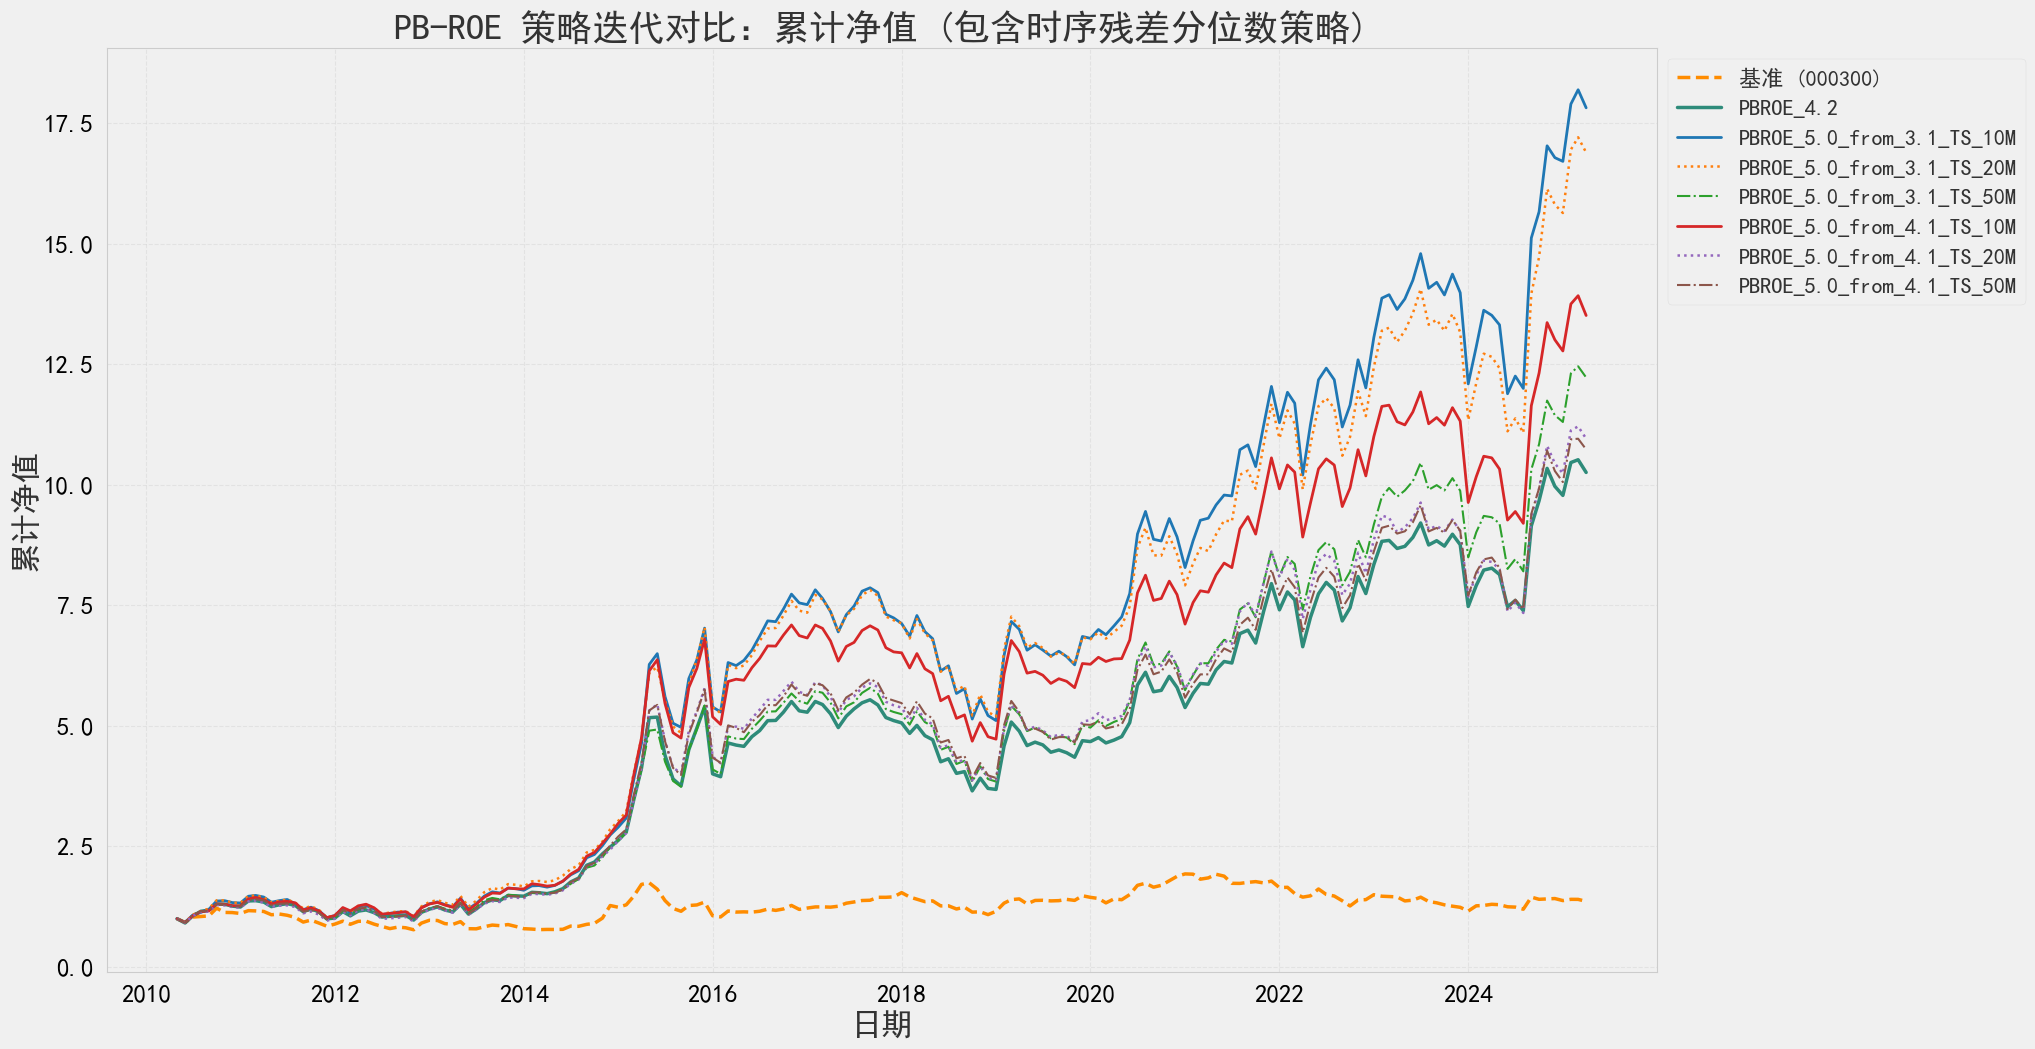

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns # 导入seaborn用于获取更多颜色

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
# PBROE 5.0系列策略和基准的累计收益文件 (由之前的批量回测生成)
FILE_PBROE5_ALL_CUMULATIVE = Path("E:\PBROE\ch5\pbroe5.2all_cumulative_returns.csv") # 假设是这个文件名
# PBROE 4.2策略的月度收益文件 (需要计算累计收益)
FILE_PBROE4_2_RETURNS = Path("E:/PBROE/ch4/pbroe4.2_returns.csv")

# --- 输出配置 ---
output_dir = Path("./ch5_pics") # 新的输出目录，用于存放第五章的图表
output_dir.mkdir(exist_ok=True) # 确保输出目录存在


# =================================================================== #
#                       【2. 样式与颜色配置】                         #
# =================================================================== #

def get_academic_colors():
    """返回您指定的学术风格色板"""
    return {
        'primary': '#333333',
        'secondary': '#000000',
        'background': '#F0F0F0',
        'gridline': '#D9D9D9',
        'categorical': [
            '#FF8C00',  # 明亮橙色 (作为基准色)
            '#6A7FDB',  # 明亮靛蓝 (主策略色)
            '#2E8B7A',  # 深青 (次策略色)
            '#A0522D',  # 深红棕色
            '#DA70D6',  # 明亮兰花紫
            '#87CEEB',  # 天蓝色
            '#C7C7C7',  # 灰色
            '#808000',  # 橄榄绿
            '#4682B4',  # 钢蓝色
            '#D2691E',  # 巧克力色
            '#9ACD32',  # 黄绿色
            '#BA55D3'   # 中兰花紫
        ]
    }

def set_academic_style():
    """设置图表的全局学术风格"""
    colors = get_academic_colors()
    plt.style.use('seaborn-v0_8-paper')
    # 核心修正：提供一个备选字体列表，以增强中文兼容性
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'Microsoft JhengHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
    plt.rcParams['figure.facecolor'] = colors['background']
    plt.rcParams['axes.facecolor'] = colors['background']
    plt.rcParams['text.color'] = colors['primary']
    plt.rcParams['axes.labelcolor'] = colors['primary']
    plt.rcParams['xtick.color'] = colors['secondary']
    plt.rcParams['ytick.color'] = colors['secondary']
    plt.rcParams['grid.color'] = colors['gridline']
    plt.rcParams['font.size'] = 18 # 基础字体大小

set_academic_style()


# =================================================================== #
#                       【3. 数据加载与合并】                         #
# =================================================================== #

def load_and_merge_all_strategies(file_pbroe5_all_cumulative, file_pbroe4_2_returns):
    """
    加载 PBROE 5.0 系列策略和基准的累计收益，并计算 PBROE 4.2 的累计收益并合并。
    参数:
        file_pbroe5_all_cumulative (Path): 包含 PBROE 5.0 系列策略和基准累计收益的文件路径。
        file_pbroe4_2_returns (Path): 包含 PBROE 4.2 月度收益的文件路径。
    返回:
        pd.DataFrame: 包含所有策略和基准累计收益的合并DataFrame，如果加载失败则返回 None。
    """
    print("--- 开始加载和合并所有策略数据 ---")

    # 加载 PBROE 5.0 策略和基准的累计收益
    try:
        df_pbroe5_all = pd.read_csv(file_pbroe5_all_cumulative)
        df_pbroe5_all['date'] = pd.to_datetime(df_pbroe5_all['date'])
        df_pbroe5_all.set_index('date', inplace=True)
        print(f"成功加载 PBROE 5.0 系列策略累计收益文件: {file_pbroe5_all_cumulative.name} ({len(df_pbroe5_all)}条记录)")
    except FileNotFoundError as e:
        print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
        return None
    except Exception as e:
        print(f"加载 PBROE 5.0 文件时发生错误: {e}")
        return None

    # 加载 PBROE 4.2 月度收益并计算累计收益
    try:
        df_pbroe4_2 = pd.read_csv(file_pbroe4_2_returns)
        df_pbroe4_2.rename(columns={'portfolio_return': 'return_p4_2'}, inplace=True)
        df_pbroe4_2['date'] = pd.to_datetime(df_pbroe4_2['date'])
        df_pbroe4_2.set_index('date', inplace=True)

        # 计算 PBROE 4.2 的累计收益
        # 确保它从其第一个可用日期开始归一化到1
        df_pbroe4_2['PBROE_4.2'] = (1 + df_pbroe4_2['return_p4_2']).cumprod()
        if not df_pbroe4_2.empty:
            df_pbroe4_2['PBROE_4.2'] = df_pbroe4_2['PBROE_4.2'] / df_pbroe4_2['PBROE_4.2'].iloc[0]

        print(f"成功加载并计算 PBROE 4.2 累计收益文件: {file_pbroe4_2_returns.name} ({len(df_pbroe4_2)}条记录)")
    except FileNotFoundError as e:
        print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
        return None
    except Exception as e:
        print(f"加载 PBROE 4.2 文件时发生错误: {e}")
        return None

    # 合并两个 DataFrame
    # 使用 outer merge 保留所有日期，然后进行前向填充和后向填充处理NaN值
    df_merged_all = pd.merge(
        df_pbroe5_all,
        df_pbroe4_2[['PBROE_4.2']], # 只选择 PBROE_4.2 累计收益列
        left_index=True,
        right_index=True,
        how='outer'
    ).sort_index()

    # 填充NaN值：前向填充，然后后向填充（处理最开始的NaN）
    df_merged_all.ffill(inplace=True)
    df_merged_all.bfill(inplace=True)

    # 再次归一化所有策略，确保它们在最早的共同起始日期都从1开始
    # 找到所有策略的共同起始日期
    earliest_common_date = df_merged_all.first_valid_index()
    if earliest_common_date is not None:
        for col in df_merged_all.columns:
            if df_merged_all.loc[earliest_common_date, col] != 0: # 避免除以零
                df_merged_all[col] = df_merged_all[col] / df_merged_all.loc[earliest_common_date, col]
            else:
                # 如果某个策略在最早共同日期为0，则将其后续值也设为0或NaN，避免误导
                df_merged_all[col] = np.nan # 或者 df_merged_all[col] = 0
                print(f"警告: 策略 '{col}' 在最早共同日期为0，其累计收益可能不准确。")
    else:
        print("警告: 合并后的DataFrame没有有效的共同起始日期。")


    print("所有策略数据加载和合并完成。\n")
    return df_merged_all

# 加载并合并所有策略数据
df_all_strategies = load_and_merge_all_strategies(FILE_PBROE5_ALL_CUMULATIVE, FILE_PBROE4_2_RETURNS)

if df_all_strategies is None:
    # 如果数据加载失败，则退出脚本
    print("数据加载失败，无法进行绘图。")
    exit() # 在脚本中直接退出


# =================================================================== #
#                     【4. 绘制所有策略累计净值对比图】               #
# =================================================================== #

def plot_all_cumulative_returns(df):
    """
    绘制所有策略与基准的累计收益曲线。
    参数:
        df (pd.DataFrame): 包含所有策略和基准累计收益的DataFrame。
    """
    print("--- 正在绘制所有策略累计净值对比图 ---")

    colors = get_academic_colors()['categorical']

    plt.figure(figsize=(20, 12)) # 较大的图表尺寸以容纳更多线条

    # 定义绘图顺序和颜色/线型映射
    # 优先绘制基准，然后是PBROE 4.2，接着是PBROE 5.0系列
    plot_order = [
        '基准 (000300)',
        'PBROE_4.2',
        'PBROE_5.0_from_3.1_TS_10M',
        'PBROE_5.0_from_3.1_TS_20M',
        'PBROE_5.0_from_3.1_TS_50M',
        'PBROE_5.0_from_4.1_TS_10M',
        'PBROE_5.0_from_4.1_TS_20M',
        'PBROE_5.0_from_4.1_TS_50M'
    ]

    # 过滤掉DataFrame中不存在的列
    columns_to_plot = [col for col in plot_order if col in df.columns]

    # 使用更丰富的颜色调色板来区分不同策略
    # 可以使用 seaborn.color_palette 获得更多颜色
    sns_palette = sns.color_palette("tab10", n_colors=10) # 10种离散颜色

    # 手动映射颜色和线型，确保可读性
    line_styles_map = {
        '基准 (000300)': {'color': colors[0], 'linestyle': '--', 'linewidth': 2.5}, # 橙色虚线，较粗
        'PBROE_4.2': {'color': colors[2], 'linestyle': '-', 'linewidth': 2.5}, # 深青实线，较粗

        # PBROE 5.0 from 3.1 系列 (使用靛蓝色系，不同线型区分周期)
        'PBROE_5.0_from_3.1_TS_10M': {'color': sns_palette[0], 'linestyle': '-', 'linewidth': 2.0},
        'PBROE_5.0_from_3.1_TS_20M': {'color': sns_palette[1], 'linestyle': ':', 'linewidth': 1.8},
        'PBROE_5.0_from_3.1_TS_50M': {'color': sns_palette[2], 'linestyle': '-.', 'linewidth': 1.5},

        # PBROE 5.0 from 4.1 系列 (使用绿色系，不同线型区分周期)
        'PBROE_5.0_from_4.1_TS_10M': {'color': sns_palette[3], 'linestyle': '-', 'linewidth': 2.0},
        'PBROE_5.0_from_4.1_TS_20M': {'color': sns_palette[4], 'linestyle': ':', 'linewidth': 1.8},
        'PBROE_5.0_from_4.1_TS_50M': {'color': sns_palette[5], 'linestyle': '-.', 'linewidth': 1.5},
    }

    # 绘制每条曲线
    for col_name in columns_to_plot:
        params = line_styles_map.get(col_name, {'color': 'gray', 'linestyle': '-', 'linewidth': 1.0}) # 默认灰色
        plt.plot(df.index, df[col_name], label=col_name, **params)

    plt.title('PB-ROE 策略迭代对比：累计净值 (包含时序残差分位数策略)', fontsize=26, fontweight='bold')
    plt.xlabel('日期', fontsize=22)
    plt.ylabel('累计净值', fontsize=22)
    plt.grid(True, which="both", linestyle='--', alpha=0.6)

    # 调整图例位置，使其不遮挡图表内容，并放大字体
    plt.legend(fontsize=16, bbox_to_anchor=(1, 1))

    plt.tick_params(axis='both', which='major', labelsize=18) # 放大坐标轴刻度字体


    save_path = output_dir / 'pbroe_all_strategies_cumulative_comparison.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"所有策略累计净值对比图已保存至: {save_path}\n")
    plt.show()

# 执行绘图
plot_all_cumulative_returns(df_all_strategies)



--- 开始加载和准备月度收益数据 ---
成功加载 PBROE 5.0 系列累计收益并转换为月度收益。
成功加载 PBROE 4.2 月度收益文件。
所有策略月度收益数据加载和合并完成。

--- 正在绘制年度收益对比图 ---

--- 年度收益数据表 ---
      PBROE 5.0 (时序10M)  PBROE 4.2     沪深300
年份                                          
2010           0.450168   0.219423  0.151250
2011          -0.140003  -0.139612 -0.177455
2012           0.000385  -0.014053 -0.068104
2013           0.326764   0.331607 -0.117945
2014           1.800859   1.712074  1.200385
2015           0.348077   0.115795 -0.335406
2016           0.179175   0.141053  0.089651
2017          -0.056420  -0.086325  0.092196
2018           0.006763   0.019222  0.041611
2019           0.010301  -0.037762 -0.000161
2020           0.315938   0.246470  0.309493
2021           0.096188   0.132500 -0.216113
2022           0.336483   0.306845  0.003198
2023          -0.008876  -0.047012 -0.105405
2024           0.318426   0.240045  0.046105
年度收益对比图已保存至: ch5_pics\pbroe_annual_returns_comparison_v2.png



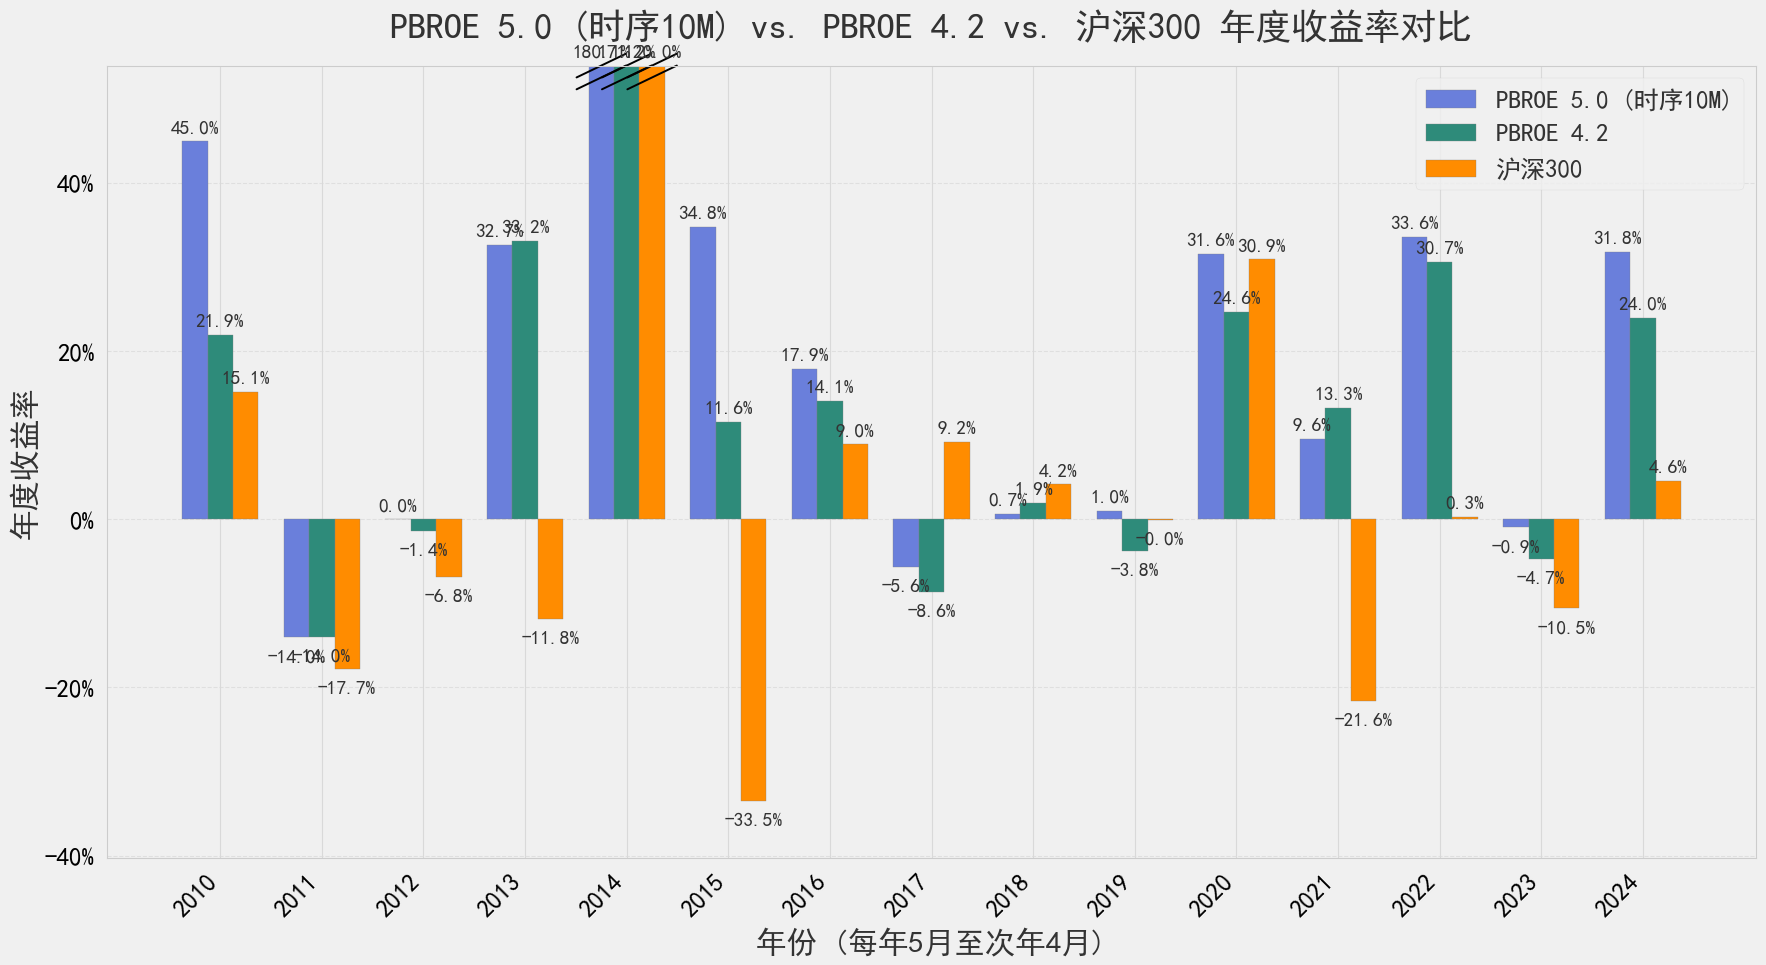

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns # 导入seaborn用于获取更多颜色

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
# PBROE 5.0系列策略和基准的累计收益文件 (由之前的批量回测生成)
FILE_PBROE5_ALL_CUMULATIVE = Path("E:\PBROE\ch5\pbroe5.2all_cumulative_returns.csv")
# PBROE 4.2策略的月度收益文件
FILE_PBROE4_2_RETURNS = Path("E:/PBROE/ch4/pbroe4.2_returns.csv")

# --- 输出配置 ---
output_dir = Path("./ch5_pics") # 新的输出目录，用于存放第五章的图表
output_dir.mkdir(exist_ok=True) # 确保输出目录存在


# =================================================================== #
#                       【2. 样式与颜色配置】                         #
# =================================================================== #

def get_academic_colors():
    """返回您指定的学术风格色板"""
    return {
        'primary': '#333333',
        'secondary': '#000000',
        'background': '#F0F0F0',
        'gridline': '#D9D9D9',
        'categorical': [
            '#FF8C00',  # 明亮橙色 (作为基准色)
            '#6A7FDB',  # 明亮靛蓝 (主策略色)
            '#2E8B7A',  # 深青 (次策略色)
            '#A0522D',  # 深红棕色
            '#DA70D6',  # 明亮兰花紫
            '#87CEEB',  # 天蓝色
            '#C7C7C7',  # 灰色
            '#808000',  # 橄榄绿
            '#4682B4',  # 钢蓝色
            '#D2691E',  # 巧克力色
            '#9ACD32',  # 黄绿色
            '#BA55D3'   # 中兰花紫
        ]
    }

def set_academic_style():
    """设置图表的全局学术风格"""
    colors = get_academic_colors()
    plt.style.use('seaborn-v0_8-paper')
    # 核心修正：提供一个备选字体列表，以增强中文兼容性
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'Microsoft JhengHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
    plt.rcParams['figure.facecolor'] = colors['background']
    plt.rcParams['axes.facecolor'] = colors['background']
    plt.rcParams['text.color'] = colors['primary']
    plt.rcParams['axes.labelcolor'] = colors['primary']
    plt.rcParams['xtick.color'] = colors['secondary']
    plt.rcParams['ytick.color'] = colors['secondary']
    plt.rcParams['grid.color'] = colors['gridline']
    plt.rcParams['font.size'] = 18 # 基础字体大小

set_academic_style()


# =================================================================== #
#                       【3. 数据加载与准备月度收益】                 #
# =================================================================== #

def load_and_prepare_monthly_returns(file_pbroe5_all_cumulative, file_pbroe4_2_returns):
    """
    加载指定策略的累计收益和月度收益文件，并统一转换为月度收益率。
    参数:
        file_pbroe5_all_cumulative (Path): 包含 PBROE 5.0 系列策略和基准累计收益的文件路径。
        file_pbroe4_2_returns (Path): 包含 PBROE 4.2 月度收益的文件路径。
    返回:
        pd.DataFrame: 包含所有选定策略和基准月度收益率的合并DataFrame，如果加载失败则返回 None。
    """
    print("--- 开始加载和准备月度收益数据 ---")

    # 1. 加载 PBROE 5.0 策略和基准的累计收益，并转换为月度收益
    df_pbroe5_monthly = pd.DataFrame()
    try:
        df_pbroe5_all_cum = pd.read_csv(file_pbroe5_all_cumulative)
        df_pbroe5_all_cum['date'] = pd.to_datetime(df_pbroe5_all_cum['date'])
        df_pbroe5_all_cum.set_index('date', inplace=True)

        # 提取 PBROE 5.0_from_3.1_TS_10M 策略和基准的累计收益
        columns_to_extract_p5 = ['PBROE_5.0_from_3.1_TS_10M', '基准 (000300)']

        # 检查列是否存在，如果不存在则跳过或报错
        missing_cols_p5 = [col for col in columns_to_extract_p5 if col not in df_pbroe5_all_cum.columns]
        if missing_cols_p5:
            print(f"错误: PBROE 5.0 累计收益文件中缺少列: {missing_cols_p5}")
            return None

        df_pbroe5_selected_cum = df_pbroe5_all_cum[columns_to_extract_p5].copy()

        # 将累计收益转换为月度收益
        # 考虑到起始点可能不是1，使用 .shift(1) 来计算正确的月度收益
        df_pbroe5_monthly = df_pbroe5_selected_cum / df_pbroe5_selected_cum.shift(1) - 1
        df_pbroe5_monthly.fillna(0, inplace=True) # 第一个月的NaN填充为0

        print(f"成功加载 PBROE 5.0 系列累计收益并转换为月度收益。")
    except FileNotFoundError as e:
        print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
        return None
    except Exception as e:
        print(f"处理 PBROE 5.0 文件时发生错误: {e}")
        return None

    # 2. 加载 PBROE 4.2 月度收益
    df_pbroe4_2_monthly = pd.DataFrame()
    try:
        df_pbroe4_2_monthly = pd.read_csv(file_pbroe4_2_returns)
        df_pbroe4_2_monthly.rename(columns={'portfolio_return': 'PBROE_4.2', 'benchmark_return': 'benchmark_return_p4_2'}, inplace=True)
        df_pbroe4_2_monthly['date'] = pd.to_datetime(df_pbroe4_2_monthly['date'])
        df_pbroe4_2_monthly.set_index('date', inplace=True)
        print(f"成功加载 PBROE 4.2 月度收益文件。")
    except FileNotFoundError as e:
        print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
        return None
    except KeyError as e:
        print(f"错误: PBROE 4.2 月度收益文件中未找到列 '{e}'。请检查列名。")
        return None
    except Exception as e:
        print(f"处理 PBROE 4.2 文件时发生错误: {e}")
        return None

    # 3. 合并所有月度收益数据
    # 使用 outer merge 保留所有日期，然后进行前向填充和后向填充处理NaN值
    # 优先使用 PBROE 5.0 文件中的基准收益，因为它可能更权威或与 PBROE 5.0 策略计算方式一致
    df_merged_monthly = pd.merge(
        df_pbroe5_monthly[['PBROE_5.0_from_3.1_TS_10M', '基准 (000300)']],
        df_pbroe4_2_monthly[['PBROE_4.2']], # 只取 PBROE_4.2 策略收益
        left_index=True,
        right_index=True,
        how='outer'
    ).sort_index()

    # 确保所有列都是数值类型，并填充合并后可能出现的NaN值
    for col in df_merged_monthly.columns:
        df_merged_monthly[col] = pd.to_numeric(df_merged_monthly[col], errors='coerce')
    df_merged_monthly.fillna(0, inplace=True) # 填充为0，表示无收益

    print("所有策略月度收益数据加载和合并完成。\n")
    return df_merged_monthly

# 加载并准备月度收益数据
df_monthly_returns = load_and_prepare_monthly_returns(FILE_PBROE5_ALL_CUMULATIVE, FILE_PBROE4_2_RETURNS)

if df_monthly_returns is None:
    print("数据加载失败，无法进行绘图。")
    exit() # 在脚本中直接退出


# =================================================================== #
#                     【4. 绘制年度收益对比柱状图】                   #
# =================================================================== #

def plot_annual_returns_comparison(df_monthly_returns):
    """
    绘制指定策略与基准的年度收益对比柱状图。
    参数:
        df_monthly_returns (pd.DataFrame): 包含月度收益率的DataFrame。
                                         应包含 'PBROE_5.0_from_3.1_TS_10M', 'PBROE_4.2', '基准 (000300)' 列。
    """
    print("--- 正在绘制年度收益对比图 ---")

    # 定义要绘制的策略和它们的显示名称
    strategies_to_plot = {
        'PBROE_5.0_from_3.1_TS_10M': 'PBROE 5.0 (时序10M)',
        'PBROE_4.2': 'PBROE 4.2',
        '基准 (000300)': '沪深300'
    }

    # 过滤DataFrame，只保留需要绘制的列
    columns_to_include = [col for col in strategies_to_plot.keys() if col in df_monthly_returns.columns]
    if not columns_to_include:
        print("错误: 找不到任何要绘制的策略或基准列。")
        return

    df_plot = df_monthly_returns[columns_to_include].copy()

    # 计算 "策略年度" (每年5月至次年4月)
    df_plot['策略年度'] = df_plot.index.year - (df_plot.index.month < 5)

    # 计算每个策略/基准的年度收益
    # Group by '策略年度' and calculate (1 + monthly_return).prod() - 1
    annual_returns = df_plot.groupby('策略年度')[columns_to_include].apply(lambda x: (1 + x).prod() - 1)
    annual_returns.rename(columns=strategies_to_plot, inplace=True) # 重命名列，用于图例
    annual_returns.index.name = '年份' # 重命名索引

    print("\n--- 年度收益数据表 ---")
    print(annual_returns)

    fig, ax = plt.subplots(figsize=(18, 10)) # 增加图表尺寸
    bar_width = 0.25 # 调整柱子宽度以适应3个柱子

    # X轴上每个年份组的起始位置
    r_years = np.arange(len(annual_returns.index))
    r_strategy1 = r_years - bar_width
    r_strategy2 = r_years
    r_benchmark = r_years + bar_width

    colors = get_academic_colors()['categorical']

    # 绘制柱状图
    bars1 = ax.bar(r_strategy1, annual_returns['PBROE 5.0 (时序10M)'], color=colors[1], width=bar_width, edgecolor='grey', label='PBROE 5.0 (时序10M)') # 靛蓝
    bars2 = ax.bar(r_strategy2, annual_returns['PBROE 4.2'], color=colors[2], width=bar_width, edgecolor='grey', label='PBROE 4.2') # 深青
    bars3 = ax.bar(r_benchmark, annual_returns['沪深300'], color=colors[0], width=bar_width, edgecolor='grey', label='沪深300') # 橙色

    ax.set_title('PBROE 5.0 (时序10M) vs. PBROE 4.2 vs. 沪深300 年度收益率对比', fontsize=26, pad=20, fontweight='bold')
    ax.set_xlabel('年份 (每年5月至次年4月)', fontsize=22) # 增大字体
    ax.set_ylabel('年度收益率', fontsize=22) # 增大字体

    # 设置X轴刻度位置和标签
    ax.set_xticks(r_years)
    ax.set_xticklabels(annual_returns.index, rotation=45, ha="right", fontsize=18) # 增大字体，调整对齐

    ax.legend(fontsize=18) # 增大图例字体
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

    ax.tick_params(axis='y', labelsize=18) # 增大Y轴刻度字体

    # --- 核心修正：2014年柱子截断逻辑，并确保所有标签显示 ---
    # 找到2014年的数据索引
    year_2014_exists = 2014 in annual_returns.index
    year_2014_index = annual_returns.index.get_loc(2014) if year_2014_exists else -1

    # 获取除2014年外的其他年份的收益范围，用于设置Y轴限制
    other_years_annual_returns = annual_returns.drop(index=2014, errors='ignore')

    y_limit_top = None
    y_limit_bottom = None

    if not other_years_annual_returns.empty:
        min_y_other = other_years_annual_returns.min().min()
        max_y_other = other_years_annual_returns.max().max()

        # 动态设置Y轴显示范围，确保大部分数据可见，并为截断留出空间
        # 这里的0.5和-0.2是经验值，可以根据实际数据分布调整
        y_limit_top = max(0.5, max_y_other * 1.2) if max_y_other > 0 else 0.5 # 确保上限至少为0.5
        y_limit_bottom = min(min_y_other * 1.2, -0.2) if min_y_other < 0 else -0.2 # 确保下限至少为-0.2

        ax.set_ylim(y_limit_bottom, y_limit_top)

    # 绘制截断标记的参数
    d = .015 # 截断标记的长度
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False) # 黑色，不裁剪

    # 遍历所有柱子，添加标签和截断标记
    for i, year in enumerate(annual_returns.index):
        for bar_set in [bars1, bars2, bars3]:
            bar = bar_set[i]
            height = bar.get_height()

            # 检查是否是2014年的柱子，并且其高度是否超出显示范围
            is_2014_and_truncated = (year == 2014 and year_2014_exists and
                                     ((y_limit_top is not None and height > y_limit_top) or
                                      (y_limit_bottom is not None and height < y_limit_bottom)))

            if is_2014_and_truncated:
                # 标签位置：放在截断处
                if height > y_limit_top:
                    annotate_y = y_limit_top
                    va = 'bottom'
                    offset_y = 5
                    # 绘制顶部截断标记
                    x_data_pos = bar.get_x() + bar.get_width() / 2
                    x_ax_norm, _ = ax.transAxes.inverted().transform(ax.transData.transform((x_data_pos, y_limit_top)))
                    ax.plot((x_ax_norm - d, x_ax_norm + d), (1 - d, 1 + d), **kwargs) # 顶部横线
                    ax.plot((x_ax_norm - d, x_ax_norm + d), (1 - 2*d, 1), **kwargs) # 顶部斜线
                else: # height < y_limit_bottom
                    annotate_y = y_limit_bottom
                    va = 'top'
                    offset_y = -8
                    # 绘制底部截断标记
                    x_data_pos = bar.get_x() + bar.get_width() / 2
                    x_ax_norm, _ = ax.transAxes.inverted().transform(ax.transData.transform((x_data_pos, y_limit_bottom)))
                    ax.plot((x_ax_norm - d, x_ax_norm + d), (0, d), **kwargs) # 底部横线
                    ax.plot((x_ax_norm - d, x_ax_norm + d), (0, 2*d), **kwargs) # 底部斜线

                ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width() / 2, annotate_y),
                            xytext=(0, offset_y), textcoords="offset points", ha='center', va=va, fontsize=14)
            else:
                # 正常标签位置
                va = 'bottom' if height >= 0 else 'top'
                offset_y = 5 if height >= 0 else -8
                ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, offset_y), textcoords="offset points", ha='center', va=va, fontsize=14)

    plt.tight_layout()
    save_path = output_dir / 'pbroe_annual_returns_comparison_v2.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"年度收益对比图已保存至: {save_path}\n")
    plt.show()

# 执行绘图
plot_annual_returns_comparison(df_monthly_returns)

